# Iterative Conflict-Minimizing Optimization (2023-01-04)

We iteratively add paths to the solution. The solution remaings feasible all the
time. The special thing is that we compute the path in two iterations and may
change previous paths. The first iterations  allows a limited number of conflicts.
In  the second iteration we replan the path with all the conflicting paths.

##  Instance

We aim for 30x30 instances with some obstacles and maybe 100 agents.

In [9]:
import itertools
import networkx as nx
import random

# Environment
width = 15
obstacles = [(7, 0), (7, 1), (7, 3), (7, 4), (7, 5), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13),
             (9, 15), (9, 14), (9, 13), (9, 12), (9, 11), (9, 10), (5, 15), (5, 14), (5, 13), (5, 12), (5, 11), (5, 10),
             (5, 9), (5, 8)]

graph = nx.Graph()
for i, j in itertools.product(range(width), range(width)):
    if (i, j) in obstacles:
        continue
    if (i, j + 1) not in obstacles:
        graph.add_edge((i, j), (i, j + 1))
    if (i + 1, j) not in obstacles:
        graph.add_edge((i, j), (i + 1, j))
    if (i + 1, j + 1) in obstacles:
        continue
    if (i, j + 1) not in obstacles:
        graph.add_edge((i + 1, j + 1), (i, j + 1))
    if (i + 1, j) not in obstacles:
        graph.add_edge((i + 1, j + 1), (i + 1, j))

# Agents with origin and destination
n_robots = 50
nodes = list(graph.nodes)
sources = random.sample(nodes, n_robots)
targets = random.sample(nodes, n_robots)
targets = [(sources[i], targets[i]) for i in range(n_robots)]

In [10]:
all_pairs_shortest_path = dict(nx.all_pairs_shortest_path_length(graph))
from conflict_minimization.flow_graph import SingleRobotFlowGraph

flow_graphs = [SingleRobotFlowGraph(i, origin=targets[i][0], target=targets[i][1], n=max(
    len(nx.shortest_path(graph, source, target)) for source, target in targets) + 10, graph=graph,
                                    all_pairs_shortest_path=all_pairs_shortest_path) for i in
               range(n_robots)]


##  Instance

We aim for 30x30 instances with some obstacles and maybe 100 agents.

In [11]:
import itertools
import networkx as nx
import random

# Environment
width = 15
obstacles = [(7, 0), (7, 1), (7, 3), (7, 4), (7, 5), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13),
             (9, 15), (9, 14), (9, 13), (9, 12), (9, 11), (9, 10), (5, 15), (5, 14), (5, 13), (5, 12), (5, 11), (5, 10),
             (5, 9), (5, 8)]

graph = nx.Graph()
for i, j in itertools.product(range(width), range(width)):
    if (i, j) in obstacles:
        continue
    if (i, j + 1) not in obstacles:
        graph.add_edge((i, j), (i, j + 1))
    if (i + 1, j) not in obstacles:
        graph.add_edge((i, j), (i + 1, j))
    if (i + 1, j + 1) in obstacles:
        continue
    if (i, j + 1) not in obstacles:
        graph.add_edge((i + 1, j + 1), (i, j + 1))
    if (i + 1, j) not in obstacles:
        graph.add_edge((i + 1, j + 1), (i + 1, j))

# Agents with origin and destination
n_robots = 75
nodes = list(graph.nodes)
sources = random.sample(nodes, n_robots)
targets = random.sample(nodes, n_robots)
targets = [(sources[i], targets[i]) for i in range(n_robots)]

In [12]:
all_pairs_shortest_path = dict(nx.all_pairs_shortest_path_length(graph))
from conflict_minimization.flow_graph import SingleRobotFlowGraph

flow_graphs = [SingleRobotFlowGraph(i, origin=targets[i][0], target=targets[i][1], n=max(
    len(nx.shortest_path(graph, source, target)) for source, target in targets) + 10, graph=graph,
                                    all_pairs_shortest_path=all_pairs_shortest_path) for i in
               range(n_robots)]

def extend_path(path, n):
    assert len(path) <= n
    return [path[i] if i < len(path) else path[-1] for i in range(n)]


def equalize_path_lengths(paths):
    max_length = max(len(path) for path in paths)
    return [extend_path(path, max_length) for path in paths]


def do_have_conflict(path_a, path_b):
    assert len(path_a) == len(path_b)
    n = len(path_a)
    for i in range(n):
        if path_a[i] == path_b[i]:
            return True
        if i > 0 and path_a[i] == path_b[i - 1] and path_b[i] == path_a[i - 1]:
            return True
    return False

def get_conflicting_ids(solution):
    solution = equalize_path_lengths(solution)
    conflict_graph = nx.Graph()
    result = set()
    for i, j in itertools.combinations(range(len(solution)), 2):
        if do_have_conflict(solution[i], solution[j]):
            result.add(i)
            result.add(j)
    print(f"Solution has {conflict_graph.number_of_edges()} conflicts.")
    return result

from conflict_minimization.multi_robot_model import MultiRobotFlowModel
initial_solution = []
for i in range(n_robots):
    assert len(initial_solution) == i
    model = MultiRobotFlowModel([flow_graphs[i]])
    for j, path in enumerate(initial_solution):
        model.add_path(j, path)
    model.set_objective(1)
    model.add_conflict_limit(4)
    paths = model.optimize(60)
    initial_solution += paths
    assert len(initial_solution) == i+1
    subset = list(get_conflicting_ids(initial_solution))
    if not subset:
        continue
    model = MultiRobotFlowModel([flow_graphs[j] for j in subset])
    for j, path in enumerate(initial_solution):
        if j not  in  subset:
            model.add_path(j, path)
    model.set_objective(1)
    model.add_conflict_limit(0)
    cf_paths = model.optimize(60)
    for robot, path  in zip(subset, cf_paths, strict=True):
        print(robot)
        initial_solution[robot] = path

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8559U CPU @ 2.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2063 rows, 8499 columns and 16998 nonzeros
Model fingerprint: 0xa7259082
Variable types: 0 continuous, 8499 integer (8499 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 104 rows and 126 columns
Presolve time: 0.07s
Presolved: 1959 rows, 8373 columns, 16746 nonzeros
Variable types: 0 continuous, 8373 integer (8373 binary)
Found heuristic solution: objective 22.0000000

Root relaxation: cutoff, 1678 iterations, 0.11 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    

AttributeError: Unable to retrieve attribute 'X'

In [ ]:
def objective(solution):
    obj = 0
    for path in solution:
        for i in range(len(path) - 1):
            if path[i] != path[i + 1]:
                obj += 1
    return obj

max_dist = max(len(path) for path in initial_solution)
initial_objective = objective(initial_solution)  # this only works for the initial solution (no waiting)
print(f"The initial solution has an objective of {initial_objective}. This is superoptimal.")

## Analyze conflicts and find conflict group

Find a set of paths that has conflicts and should be optimized, i.e., get their
conflicts reduced.

In [ ]:
from visualization.plot import plot_robot, plot_path


def extend_path(path, n):
    assert len(path) <= n
    return [path[i] if i < len(path) else path[-1] for i in range(n)]


def equalize_path_lengths(paths):
    max_length = max(len(path) for path in paths)
    return [extend_path(path, max_length) for path in paths]


def do_have_conflict(path_a, path_b):
    assert len(path_a) == len(path_b)
    n = len(path_a)
    for i in range(n):
        if path_a[i] == path_b[i]:
            return True
        if i > 0 and path_a[i] == path_b[i - 1] and path_b[i] == path_a[i - 1]:
            return True
    return False

def get_vertex_conflicts(path_a, path_b):
    assert len(path_a) == len(path_b)
    n = len(path_a)
    for i in range(n):
        if path_a[i] == path_b[i]:
            yield path_a[i]

def get_edge_conflicts(path_a, path_b):
    assert len(path_a) == len(path_b)
    n = len(path_a)
    for i in range(n):
        if i > 0 and path_a[i] == path_b[i - 1] and path_b[i] == path_a[i - 1]:
            yield path_a[i-1], path_a[i]

def get_conflicts(solution):
    vertex_conflicts = set()
    edge_conflicts = set()
    for i, j in itertools.combinations(range(len(solution)), 2):
        for vc in get_vertex_conflicts(solution[i], solution[j]):
            vertex_conflicts.add(vc)
        for ec in  get_edge_conflicts(solution[i], solution[j]):
            edge_conflicts.add(ec)
    return vertex_conflicts, edge_conflicts

def plot_conflicts(graph, solution):
    length = len(solution[0])
    colors = cm.get_cmap("tab20c", len(solution))
    fig = plt.figure(facecolor="white")
    ax = fig.gca()
    ax.set_facecolor("white")
    ax.set_aspect("equal", adjustable="box", anchor="C")
    plot_graph(ax, graph)
    for r, path in enumerate(solution):
        plot_robot(ax, path, length-1, colors(r))
        plot_path(ax, path, colors(r))
    vc, ec = get_conflicts(solution)
    for vc_ in vc:
        ax.add_patch(plt.Circle(vc_, 0.5, color="red", zorder=3, alpha=0.5))
    for ec_ in ec:
        ax.add_patch(plt.Circle((0.5*ec_[0][0]+0.5*ec_[1][0], 0.5*ec_[0][1]+0.5*ec_[1][1] ), 0.5, color="red", zorder=3, alpha=0.5))
        #ax.add_patch(plt.Circle(ec_[1], 0.5, color="red", zorder=3, alpha=0.5))
    plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import networkx as nx
import typing
from matplotlib import cm
from IPython import display


class Robot:
    def __init__(self, ax, path, color):
        self._path = path
        self._path_line, = ax.plot([p[0] for p in self._path[:1]], [p[1] for p in self._path[:1]],
                                   zorder=2, color=color, alpha=0.7, lw=4)
        self._outer_circle = plt.Circle(self._path[0], 0.32, color="black", zorder=4)
        self._inner_circle = plt.Circle(self._path[0], 0.3, color=color, zorder=5)
        self._shadows = [plt.Circle(self._path[0], 0.3, color=color, zorder=3, alpha=t ** 3, linewidth=0) for t in
                         [0.6, 0.7, 0.8, 0.9]]
        ax.add_patch(self._outer_circle)
        ax.add_patch(self._inner_circle)
        for c in self._shadows:
            ax.add_patch(c)

    def move(self, i):
        self._path_line.set_data([p[0] for p in self._path[:i + 1]], [p[1] for p in self._path[:i + 1]])
        pos = self._path[i]
        prev_pos = self._path[i - 1] if i > 0 else self._path[0]
        self._outer_circle.center = pos
        self._inner_circle.center = pos
        for i_, t in enumerate([0.6, 0.7, 0.8, 0.9]):
            x = t * pos[0] + (1 - t) * prev_pos[0]
            y = t * pos[1] + (1 - t) * prev_pos[1]
            self._shadows[i_].center = (x, y)


def plot_graph(ax: plt.Axes, graph: nx.Graph):
    ax.plot([p[0] for p in graph.nodes], [p[1] for p in graph.nodes], "o", c="grey",
            zorder=1)
    for e in graph.edges:
        ax.plot([e[0][0], e[1][0]], [e[0][1], e[1][1]], c="grey", zorder=1, lw=1)


class AnimationFunction:
    def __init__(self, graph: nx.Graph, solution: typing.Dict):
        self.solution = solution
        self.fig = plt.figure(figsize=(7,7))
        self.ax = plt.gca()
        self.ax.set_aspect('equal', adjustable='box', anchor='C')
        plot_graph(self.ax, graph)
        colors = cm.get_cmap("tab20c", len(solution))
        self.robots = [Robot(self.ax, path, colors(i)) for i, path in enumerate(solution)]

    def __len__(self):
        return len(self.solution[0])

    def __call__(self, i):
        for r, path in enumerate(self.solution):
            self.robots[r].move(i)
        #return [robot._inner_circle for robot in self.robots]


anim_func = AnimationFunction(graph, initial_solution)
anim = FuncAnimation(anim_func.fig, func=anim_func,
                     frames=len(anim_func),
                     interval=400,
                     blit=False)
video = anim.to_jshtml()
html = display.HTML(video)
display.display(html)
plt.close()

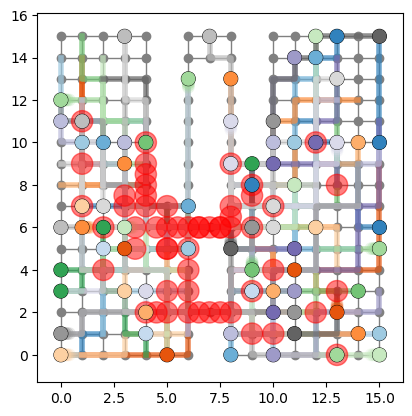

In [34]:
plot_conflicts(graph, initial_solution)